In [1]:
import torch
import math
import torch.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
"""
org from I-BERT code


"""
# def i_POLY(self, q, S, a, b, c):
#     """
#     Kim, Sehoon, et al. "I-bert: Integer-only bert quantization." International conference on machine learning. PMLR, 2021.
#     ref : https://github.com/kssteven418/I-BERT/blob/ibert/fairseq/quantization/utils/quant_modules.py

#     여기 논문에서 알고리즘 1에 _s는 floor하라고 적혀있는데 그렇게 하면 그냥 망해버림.
#     """
#     qb = torch.floor(b / S)  # PRE-COMPUTED >> INT
#     qc = torch.floor(c / (a * S**2))  # PRE-COMPUTED >> INT
#     # _S = torch.floor(a * S**2)
#     _S = a * S**2  # PRE-COMPUTED >> FP
#     _q = (q + qb) ** 2 + qc  # >> INT

#     return _q, _S  # INT, FP
# def i_ERF( q, S):
#     a, b, c = -0.2888, -1.769, 1
#     a, b, c = torch.tensor(a), torch.tensor(b), torch.tensor(c)

#     qb = torch.floor(b / S)
#     qc = torch.floor(c/ (a * S ** 2))

#     _q = torch.sign(q) * ((torch.min(torch.abs(q), -qb) + qb) ** 2 + qc)

#     S_L = a * S**2
#     print("ddfd", S_L)
#     return _q, S_L

# def i_GELU( fp, S):

#     q = (fp / S).round()
#     q_erf, S_erf = i_ERF(q, S / 1.4142)
#     q1 = torch.floor(1 / S_erf)

#     _q, _S = q * (q_erf + q1), S * S_erf / 2

#     return _q * _S , _S

'\norg from I-BERT code\n\n'

In [3]:
def i_ERF( q, S):
    with torch.no_grad():
        a, b, c = -0.2888, -1.769, 1
        a, b, c = torch.tensor(a), torch.tensor(b), torch.tensor(c)
        qb = torch.floor(b / S)  # PRE-COMPUTED >> INT
        qc = torch.floor(c / (a * S**2))  # PRE-COMPUTED >> INT

    """ONLY INT OPERATION"""
    _q = q.sign() * ((torch.min(q.abs(), -qb) + qb).pow(2) + qc)

    _S = a * S**2  # PRE-COMPUTED >> FP

    return _q, _S

def i_GELU( q, S):
    with torch.device(q.device):

        # input : (INT, PRE-COMPUTED-FP)
        q_erf, S_erf = i_ERF(q, S / 1.4142)
        # output : (INT, PRE-COMPUTED-FP)

        q1 = torch.floor(1 / S_erf)  # floor(1 / PRE-COMPUTED-FP) >> INT

        _q = q * (q_erf + q1)  # INT
        _S = S * S_erf / 2  # PRE-COMPUTED-FP

        return _q, _S


In [4]:
k = 1.4142
coeff = [-0.2888, -1.769, 1] # a(x+b)**2 + c
coeff[2] /= coeff[0]

def int_erf( x_int, scaling_factor):
    with torch.no_grad():
        b_int = torch.floor(coeff[1] / scaling_factor)
        c_int = torch.floor(coeff[2] / scaling_factor ** 2)

    with torch.no_grad():
        sign = torch.sign(x_int)
    abs_int = torch.abs(x_int)
    abs_int = torch.min(abs_int, -b_int)
    y_int = (abs_int + b_int) ** 2 + c_int
    y_int = sign * y_int
    scaling_factor = scaling_factor ** 2 * coeff[0]
    print("ddfd", scaling_factor)
    
    return y_int, scaling_factor


def INTGELU(x, scaling_factor=None):
    x_int = x / scaling_factor
    x_int = x_int.round()
    sigmoid_int, sigmoid_scaling_factor = int_erf(x_int, scaling_factor / k)

    shift_int = torch.floor(1. / sigmoid_scaling_factor)

    x_int = x_int * (sigmoid_int + shift_int)
    scaling_factor = scaling_factor * sigmoid_scaling_factor / 2
    
    return x_int * scaling_factor, scaling_factor

tensor(-0.1700) tensor(4.4709)


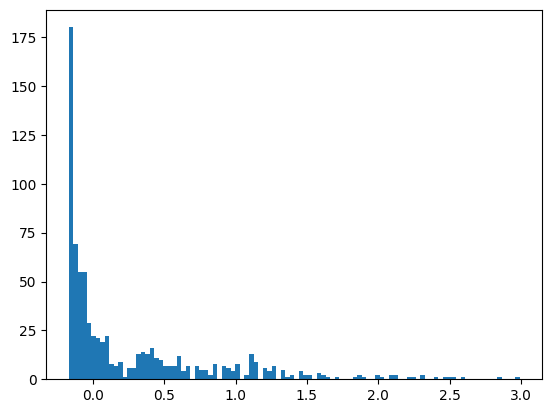

ddfd tensor(-0.0002)


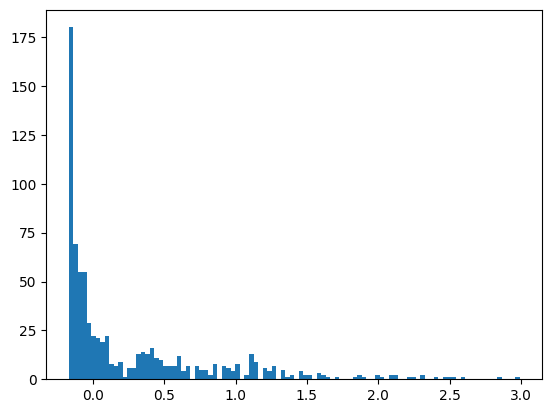

tensor(4.0554)
tensor(4.0554)
tensor(True)


In [5]:
x_fp = torch.randn((1, 197, 768))

# plt.hist(x_fp[0, 0, :].cpu().numpy(), bins=100)
# plt.show()
gelu = nn.GELU()

org_gelu_output = gelu(x_fp)
# plt.hist(org_gelu_output[0, 0, :].cpu().numpy(), bins=100)
# plt.show()

print(org_gelu_output.min(), org_gelu_output.max())


scaler = x_fp.abs().max() / 127

myint_gelu_output, _ = i_GELU((x_fp / scaler).round(), scaler)
myint_gelu_output *= _
plt.hist(myint_gelu_output[0, 0, :].cpu().numpy(), bins=100)
plt.show()

int_gelu_output, _ = INTGELU(x_fp, scaler)
plt.hist(int_gelu_output[0, 0, :].cpu().numpy(), bins=100)
plt.show()

print(torch.norm(org_gelu_output - myint_gelu_output))
print(torch.norm(org_gelu_output - int_gelu_output))
print(torch.eq(myint_gelu_output, int_gelu_output).all())